# 실습 11. 트랜스포머

In [ ]:
import string

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


<h2>0. Intro</h2>

이전 연습문제에서 Seq2Seq 모델을 살펴보았다. 이 모델은 발표된 이후 한동안 학계와 업계에서 지배적으로 활용되고 있었다. Attention 기능까지 더해지면서, Seq2Seq 모델은 대단한 성능과 학습 속도를 보여주었다. 그러나 머지않아 NLP 연구에 새 지평을 연 하나의 새로운 모델이 세상에 공개되었다.

그것은 바로 지난 2017년, 구글 브레인이 'Attention is All you Need'라는 제목의 논문으로 공개한 트랜스포머다.

논문의 제목에서 알 수 있듯이 트랜스포머는 attention을 기반으로 하며, Seq2Seq과 달리 RNN의 순환 구조가 전혀 사용되지 않았다. 즉, 한 스텝에 하나의 토큰을 처리하는 방식이 아닌, 한 번에 모든 토큰을 처리하는 방식을 취한다. 이로 인해 RNN을 기반으로 한 Seq2Seq보다 훨씬 빠르고, 모델의 복잡도가 현저히 낮다. 이전 스텝과 다음 스텝 간에 유기적인 관계를 맺고 있어 복잡한 양상을 띠는 Seq2Seq와 달리, 트랜스포머는 훨씬 더 간단하고 직관적으로 받아들일 수 있는 행렬곱들로 구성되어 있다.

NLP 학계의 연구들을 트랜스포머 이전과 이후로 구분지을 수 있을 만큼, 트랜스포머의 등장은 NLP의 발전에 지대한 영향을 끼쳤다. 2020년 6월 OpenAI에서 선보인 역대 최대 규모의 초거대 언어 AI 모델, GPT-3도 트랜스포머 기반 모델이다. 트랜스포머는 NLP뿐만 아니라 컴퓨터 비전을 비롯한 다른 분야에서도 정말 강력한 도구로서 많이 활용되고 있다.

그렇다면 트랜스포머가 도대체 무엇인가? 본 연습문제를 통해 트랜스포머 구조에 대해 깊게 들여다보고자 한다. 트랜스포머 모델을 직접 구현해보고, 이 모델에 암호를 해독하는 방법을 학습시켜보도록 할 것이다.

본격적으로 시작하기 전에, 일련의 코드를 통해 줄글 데이터를 불러오도록 하자.

In [ ]:
path = "./gdrive/MyDrive/"
path_to_wikipedia = path + "wikipedia2text-extracted.txt"
with open(path_to_wikipedia, "rb") as f:
    wikipedia = f.read().decode()
    wikipedia = wikipedia.lower()
print(str(len(wikipedia)) + " character(s)")

63291831 character(s)


In [ ]:
import re

# keep alphabet + spaces
wikipedia = re.sub("[^ a-z]", "", wikipedia) # 총 27개의 글자를 사용하는 것


In [ ]:
from itertools import zip_longest

str_len = 25
# using all data is like 30 gigs in numpy array form
percent_of_data_to_use = 0.05

wiki_ls = [''.join(filter(None, s)) for s in zip_longest(*([iter(wikipedia)]*(str_len-1)))]
wiki_ls = wiki_ls[:-1] if len(wiki_ls[-1]) != str_len else wiki_ls

wiki_ls = wiki_ls[:int(len(wiki_ls) * percent_of_data_to_use)]


In [ ]:
ALPHA = "abcdefghijklmnopqrstuvwxyz "
IND_LOOKUP = {x:i for i, x in enumerate(ALPHA)}
LOOKUP_TABLE = np.array([x for x in ALPHA])
LOOKUP_TABLE = np.concatenate([np.roll(LOOKUP_TABLE, i)[None] for i in range(0, -len(ALPHA), -1)], axis=0)


In [ ]:
LOOKUP_TABLE

array([['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
        ' '],
       ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ',
        'a'],
       ['c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
        'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', 'a',
        'b'],
       ['d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', 'a', 'b',
        'c'],
       ['e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
        'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', 'a', 'b', 'c',
        'd'],
       ['f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
        's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', 'a', 'b', 'c', 'd',
        'e'],
       ['g', 'h', 'i', 'j', 'k', 'l', 'm

In [ ]:
def cipher(plaintext, key):
    len_p = len(plaintext)
    len_k = len(key)

    key = (key * (len_p // len_k + 1))[:len_p]
    out = ""
    for p, k in zip(plaintext, key):
        ind_p = IND_LOOKUP[p]
        ind_k = IND_LOOKUP[k]

        out += LOOKUP_TABLE[ind_k, ind_p]
    return out


In [ ]:
key = "clap"

wiki_enc_ls = [cipher(x, key) for x in wiki_ls]


In [ ]:
wiki_enc_ls

['rbodcrabfl xukaoeznrgbtt',
 'fkstvkoubxegulgtukaxopdo',
 'cd xpqligycxpr hjp crtnx',
 'qysoqb qgsajkzroqq  cbgt',
 'byuadprgbzforpodnp xpctt',
 'co chkiarlrhkll  kpfqfis',
 'kygokyfctxahkznorbodcrab',
 'fl xpkihukmcud qccirbceb',
 'up dtpstpdsokyfctxahkzno',
 'ky ctoefbdookyf wpnrgkih',
 'ukaiftebep hjp aqctogqft',
 'edijgkpfq avcydpbtsoqqtt',
 'pkcco ltvplmbdrivsfinkbi',
 'vkscop dtzppilnsckpfgceb',
 'vc ucntgbce gntxxplmbdoo',
 'gyccwbavgkaorlrhknu cb g',
 ' ytwgcigbzroitvtuklccoes',
 'bxegulgtukibbzrsgb hqkpf',
 'qourgkabbpmcvtobcw fcdht',
 'tktwcy fcdicpllotpsdqyst',
 'bdoovseokyfctxahkznorbeg',
 'gyttfktwgkdtutrtfkrtuelh',
 'btsockcwcygtbzfovseoezgb',
 'kdijgknptbahkfeoqq hjp g',
 'wmjted xpktwgktptrehblus',
 'kpnrgdhtbgoffkofkribcdeg',
 'bqrcoktwgklpvtnoplmtbnob',
 'ibevcdicboeorbodcrabfl u',
 'koeoeznvtpgpvtobbqofbdht',
 'bcpfgldxpr chktwgkfpkdho',
 'qq pbnobibevcdicpkfcwydt',
 'fkbmb odgkgfgrof kxjbtno',
 'bchctdlmblfhgb hjp gvlrh',
 'bzfovseovsifvi mglrgbgaf',
 'bdhxukdtrlrh

In [ ]:
def one_hot_encoding(text):
    """
    adds both a start and end token
    """
    seq_len = len(text)
    # +2 to seq_len to add in start/end tokens, +2 to dimension to account for new start/end tokens
    # start = [... 0 1 0], end = [... 0 0 1]
    out = np.zeros((seq_len+2, len(ALPHA)+2), dtype=np.float32)
    inds = [IND_LOOKUP[x] for x in text]
    out[range(1, seq_len+1), inds] = 1
    out[0, -2] = 1
    out[-1, -1] = 1
    return out


In [ ]:
# src one-hots dont need start token
wiki_src_dat = np.concatenate([one_hot_encoding(x)[1:, None] for x in wiki_enc_ls], axis=1)

# tgt one-hots dont need end token
wiki_tgt_dat = np.concatenate([one_hot_encoding(x)[:-1, None] for x in wiki_ls], axis=1)

print(wiki_src_dat.shape, wiki_tgt_dat.shape)


(25, 125905, 29) (25, 125905, 29)


In [ ]:
# tgt inds do need end token (and no start)
wiki_tgt_inds = np.concatenate([np.array([IND_LOOKUP[x] for x in tgt_str] + [len(ALPHA) + 1]).reshape(-1, 1)
for tgt_str in wiki_ls], axis=1)

print(wiki_tgt_inds.shape)


(25, 125905)


In [ ]:
test_dat = ["i love you so much honey",
"blahblahblahblahblahblah"]

test_dat = [cipher(x, key) for x in test_dat]
test_dat = np.concatenate([one_hot_encoding(x)[1:, None] for x in test_dat], axis=1)

print(test_dat.shape)
test_dat

(25, 2, 29)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]], dtype=float32)

In [ ]:
np.savez("wikipedia2text-encoded.npz",
train_src_one_hot=wiki_src_dat,
train_tgt_one_hot=wiki_tgt_dat,
train_truth_inds=wiki_tgt_inds,
test_src_one_hot=test_dat)


<h2>1. 학습 데이터 만들기</h2>

본 문제에서는 비즈네르 암호로 인코딩된 글을 데이터셋으로 이용할 것이다. 우리는 입력받은 글에 one-hot 인코딩을 적용하여 2차원 배열로 표현하고, 여기에 비즈네르 암호 체계를 기반으로 한 인코딩 작업을 추가로 진행할 것이다. 이렇게 인코딩된 배열과 이에 대응되는 디코딩된 배열을 이용하여 트랜스포머를 학습시킬 것이다. 이를 통해 임의의 인코딩된 배열을 트랜스포머 모델에 입력했을 때, 인코딩된 문장이 무엇인지 출력할 수 있도록 할 것이다.

수열의 각 토큰들은 알파벳 소문자이거나 공백이거나 시작/끝 토큰이다. 당연히 인코딩된 배열에는 시작 토큰이 부여되어 있고, 디코딩된 수열에는 끝 토큰이 부여되어 있다. 그리고 데이터의 차원은 Seq2Seq 연습문제와 동일하다.

학습용 데이터와 테스트용 데이터를 추출하고, 각 배열의 모양을 출력해보자. 배열의 각 차원이 말하는 바가 무엇일지 생각해보자.

**Note** : 이 문제에서 수열의 길이는 시작 토큰과 끝 토큰을 포함한 길이다. 시작 토큰과 끝 토큰을 제외한 길이를 나타냈던 Seq2Seq 연습문제와는 다르다는 점에 유의하자

**Note** : [비즈네르 암호](https://ko.wikipedia.org/wiki/%EB%B9%84%EC%A6%88%EB%84%A4%EB%A5%B4_%EC%95%94%ED%98%B8#:~:text=%EB%B9%84%EC%A6%88%EB%84%A4%EB%A5%B4%20%EC%95%94%ED%98%B8(%ED%94%84%EB%9E%91%EC%8A%A4%EC%96%B4%3A%20Vigen%C3%A8re,%EC%97%90%20%EB%B0%9C%ED%91%9C%EB%90%9C%20%EC%95%94%ED%98%B8%EC%9D%B4%EB%8B%A4.)

In [ ]:
with np.load("wikipedia2text-encoded.npz") as data:
    train_src_one_hot = data["train_src_one_hot"]
    train_tgt_one_hot = data["train_tgt_one_hot"]
    train_truth_inds = data["train_truth_inds"]
    test_src_one_hot = data["test_src_one_hot"]

# 여기에 코드 작성
print(train_src_one_hot.shape, train_tgt_one_hot.shape,
      train_truth_inds.shape, test_src_one_hot.shape)

(25, 125905, 29) (25, 125905, 29) (25, 125905) (25, 2, 29)


<h2>2. 트랜스포머 모델의 구조</h2>

자, 본격적으로 연습 문제를 시작하기에 앞서, 트랜스포머의 구조를 살펴보자. 각 층이 어떤 기능을 하는지 전혀 감이 안 잡힐 수도 있겠지만, 큰 그림을 그리는데 도움이 많이 될 것이라 생각한다. 트랜스포머의 구조는 책에 수록된 그림 3.6-7과 같다.


<img src="https://drive.google.com/uc?export=view&id=1A7gEEtqkrsCFEDacbW3JGGgxCG7lsj4O" alt="no_image" style="width: 900px;"/>

트랜스포머는 크게 인코더와 디코더, 두 가지로 나눌 수 있다. 인코더의 경우, Multihead Attention 기반 층과 Feed Forward 기반 층으로 구성된 층이 N번 반복된다. 그리고 디코더의 경우, Multihead Attention 기반 층 2개와 Feed Forward 기반 층으로 구성된 층이 N번 반복된다.

입력 값과 인코더, 입력 값과 디코더 사이를 보면, Positional Encoding이라는 것이 적용된다. 후술하겠지만, 이는 입력된 각 값들의 위치 정보를 함의한다. 이렇게 각 입력 값에 위치 정보를 넣어줌으로써 RNN과 같은 순환적 구조가 아님에도 입력 값들의 위치를 트랜스포머가 인지할 수 있는 것이다.

Multihead Attention이 어떤 것인지에 대해서는 곧 서술하겠으나, 인코더의 Multihead Attention과 달리 디코더의 Multihead Attention에는 마스킹 기법이 쓰이는 것으로 보인다. 이는 디코더가 얻을 수 있는 정보를 제한하기 위함이다.

예를 들어, I want to play soccer이라는 문장을 한국어로 번역하고 있다고 생각해보자.  이것을 번역하게 된다면, ‘나는 축구를 하고 싶어’라는 문장으로 번역될 수 있을 것이다. 여기서, ‘나는 축구를’까지 해석이 되었다고 생각해보자. 그렇다면 이어서 ‘하고’라는 단어를 예측하는데 있어서 ‘나는 축구를’이 출력되었다는 정보만 다루어야 한다. 그 뒤에 나올 단어들에 대해서는 아는 정보가 없어야 한다. 상식적으로 생각해보면, 어떤 단어가 나오면 그것을 토대로 다음 단어를 예측하는 것이 골자이기에, 다음 단어를 가지고 이전 단어를 예측하는 것은 이치에 다소 어긋나는 것이다. 그렇기에 마스킹 기법을 활용하여, 뒤 토큰들의 예측 상황을 제하는 것이다.

그리고 모든 Multihead Attention과 Feed Forward 층 다음에는 Add & Norm이 있다. 이것은 앞서 ‘신경망 성능 향상을 위한 기법들’에서 다룬 Residual Connection과 Layer Normalization 기법을 의미한다. Residual Connection은 결과 값에 입력 값을 더해주는 것이므로 Add, Layer Normalization은 Norm으로 표현되었다.

구조를 한 번 훑었으니, 각 층이 구체적으로 어떤 기능을 하는지 알아보도록 하자. 특히 Multihead Attention이라는 용어가 많이 등장했는데, 이 기법이 무엇인지 한 번 자세히 들여다보자.

<h2>3. Scaled Dot Product Attention</h2>

Multihead Attention을 알아보기에 앞서, 그것의 근간을 이루는 Scaled Dot Product Attention에 대해 살펴보도록 하자. 이름에서 볼 수 있듯이 내적을 활용하며, 내적을 통해 Attention Score를 계산하는 기법이다. (* dot product = 내적)

이를 자세히 들여다보기 전에, Seq2Seq With Attention 연습문제에서 배웠던 Attention에 대해 다시 한 번 상기시켜보자.

attention 기법은 직전 디코더 hidden state와 인코더 hidden state들간의 유사도를 각각 구하여, 다음 디코더 hidden state를 생성할 때 여러 인코더 hidden state들 중 어떤 것을 중시해야 하는지 판단하는 것이다. Attention 기법을 활용하기 위해서는 인코더 hidden state들과 직전 디코더 hidden state들 사이의 관계를 나타내는 Attention Weight를 구해야 했다. 그리고 이 배열을 이용해 인코더 hidden state들의 가중합으로써 다음 디코더 hidden state를 산출했다.

Scaled Dot Product Attention도 위와 유사한 방식으로 작동한다. 정확히 어떤 방식으로 구성되어 있는지 아래에서 살펴보도록 하자.

Scaled Dot Product Attention은 이 세 가지를 입력받는다 : query Q, key K, value V

위 Q, K, V가 지칭하는 값은 아래와 같다.

- Query : 직전 디코더의 hidden state
- Key : 인코더의 전체 hidden state
- Value : 인코더의 전체 hidden state

여기서 K와 V는 같은 값을 갖는데, 각 벡터의 의미가 조금 다르다.

key의 경우, query와의 연관성 측정을 위해 즉, 직전 디코더의 hidden state와 인코더의 hidden state 사이의 관계를 파악하는 데 쓰인다. 이렇게 측정된 연관성은 Seq2Seq에서의 attention weight을 나타낸다. 그리고 value의 경우, query와 key를 통해 계산된 attention weight으로 가중합을 산출하여 궁극적으로 디코더의 새로운 hidden state를 계산해내는데 쓰인다.

어떻게 하면 attention score를 구할 수 있을까? attention score의 경우, query와 key의 내적을 통해 구할 수 있다. 그리고 여기에 softmax 함수를 적용하여 attention weight를 구한다.

이렇게 계산된 attention weight은 다음 디코더 hidden state를 계산하는 데 있어서 어떤 인코더 hidden state가 중요하게 여겨져야 할지 표현해준다. 위와 같은 연산 과정이 어떻게 이루어지는 것인지 수식을 통해 좀 더 명확히 살펴볼 수 있도록 하자.

Q는 (t, $d_k$) 모양의 배열일 것이고, K와 V는 (T, $d_k$) 모양의 배열일 것이다. 셋 모두, 각 행은 토큰을 one-hot 인코딩한 배열을 나타낸다. 예를 들어, Q의 경우 아래와 같을 것이다.

$$Q=\begin{bmatrix}\overrightarrow{q_1}\\ \overrightarrow{q_2} \\ ⦙ \\ \overrightarrow{q_t}\end{bmatrix}$$

**Note** : 여기서 각 배열의 길이를 나타내는 T와 t의 경우, 같은 값을 가져도 되고, 다른 값을 가져도 된다.

이제, Q와 K를 이용하여 attention score를 계산해보자. Q와 K의 전치 행렬에 행렬곱을 진행해서 각 query 벡터와 key 벡터의 내적을 구해볼 것이다.

$$E=QK^T=\begin{bmatrix}\overrightarrow{q_1}\\ \overrightarrow{q_2}\\ ⦙ \\ \overrightarrow{q_t}\end{bmatrix}\begin{bmatrix}\overrightarrow{k_1} & \overrightarrow{k_2} & ... & \overrightarrow{k_T}\end{bmatrix}$$

$$=\begin{bmatrix}\overrightarrow{q_1}*\overrightarrow{k_1} & \overrightarrow{q_1}*\overrightarrow{k_2} & ... & \overrightarrow{q_1}*\overrightarrow{k_T} \\ \overrightarrow{q_2}*\overrightarrow{k_1} & \overrightarrow{q_2}*\overrightarrow{k_2} & ... & \overrightarrow{q_2}*\overrightarrow{k_T} \\ ⦙ & ⦙ & & ⦙ \\ \overrightarrow{q_t}*\overrightarrow{k_1} & \overrightarrow{q_t}*\overrightarrow{k_2} & ... & \overrightarrow{q_t}*\overrightarrow{k_T}\end{bmatrix}=\begin{bmatrix}e_{1,1} & e_{1,2} & ... & e_{1,T} \\ e_{2,1} & e_{2,2} & ... & e_{2,T} \\ ⦙ & ⦙ & & ⦙ \\ e_{t,1} & e_{t,2} & ... & e_{t,T}\end{bmatrix}$$

이로써, (t, T) 모양의 배열 E가 생성되었다. 여기서 $\overrightarrow{e_{i,j}}$는 i번째 query 벡터와 j번째 key 벡터 사이의 attention score를 말한다.

이제 이 점수에 softmax 함수를 적용하여 attention weight를 계산하기 이전에, 우리는 attention score를 $\sqrt{d_k}$로 나눌 것이다.

$$E'=1/\sqrt{d_k}$$

**Note** : 이는 softmax 함수를 적용하는 데 있어 attention score의 범위를 보다 더 합리적으로 설정해준다. 절댓값이 큰 음수의 경우 softmax 함수를 적용했을 때, 0에 매우 근접한 값을 가지게 되어 훈련의 효과가 감소하게 된다. 고로 $\sqrt{d_k}$로 나눠 줌으로써 위와 같은 vanish 현상의 빈도를 줄여서 학습 효율을 높여준다.

이제 attention weight를 구하기 위해 $E'$에 softmax 함수를 적용해볼 것이다.

$$a=softmax(E')=\begin{bmatrix}softmax(e'_{1,1} & e'_{1,2} & ... & e'_{1,T}) \\ softmax(e'_{2,1} & e'_{2,2} & ... & e'_{2,T}) \\ & ⦙ & \\ softmax(e'_{t,1} & e'_{t,2} & ... & e'_{t,T})\end{bmatrix}$$

Seq2Seq에서 했던 것처럼, 우리는 이 attention weight를 이용해 value 벡터의 가중합을 구할 것이다. 아래와 같이 진행할 수 있다.

$$C=aV=\begin{bmatrix}a_{1,1} & a_{1,2} & ... & a_{1,T} \\ a_{2,1} & a_{2,2} & ... & a_{2,T} \\ ⦙ & ⦙ & & ⦙ \\ a_{t,1} & a_{t,2} & ... & a_{t,T}\end{bmatrix}\begin{bmatrix}\overrightarrow{v_1}\\ \overrightarrow{v_2} \\ ⦙ \\ \overrightarrow{v_T}\end{bmatrix}$$

$$=\begin{bmatrix} \sum_{i=1}^Ta_{1,i}(\overrightarrow{v_i})_1 & \sum_{i=1}^Ta_{1,i}(\overrightarrow{v_i})_2 & ... & \sum_{i=1}^Ta_{1,i}(\overrightarrow{v_i})_d \\ \sum_{i=1}^Ta_{2,i}(\overrightarrow{v_i})_1 & \sum_{i=1}^Ta_{2,i}(\overrightarrow{v_i})_2 & ... & \sum_{i=1}^Ta_{2,i}(\overrightarrow{v_i})_d \\ ⦙ & ⦙ & & ⦙ \\ \sum_{i=1}^Ta_{t,i}(\overrightarrow{v_i})_1 & \sum_{i=1}^Ta_{t,i}(\overrightarrow{v_i})_2 & ... & \sum_{i=1}^Ta_{t,i}(\overrightarrow{v_i})_d \end{bmatrix}=\begin{bmatrix}\overrightarrow{c_1}\\\overrightarrow{c_2}\\⦙\\\overrightarrow{c_t}\end{bmatrix}$$

위와 같이 배열 C를 계산할 수 있고, 여기서 각 행은 Seq2Seq에서의 문맥 벡터와 같은 의미를 지닌다고 생각해도 좋다. 그리고 우리는 K와 V를 같은 값을 갖는다고 가정할 것이다.
만일 이 모델을 Seq2Seq 모델의 연장선 상에서 본다면, K와 V 둘 다 $\overrightarrow{H^e}$로 볼 수 있고, Q는 $\overrightarrow{h_t^d}$로 볼 수 있다.


Scaled Dot Product Attention을 정리하자면 아래와 같이 표현할 수 있다.

$$C=Attention(Q,K,V)=softmax(QK^T/\sqrt{d_k})V$$

<h2>4. Multihead Attention</h2>

Scaled Dot Product Attention에 대해 살펴보았으니, Multihead Attention에 대해 본격적으로 살펴보자.

Scaled Dot Product Attention은 연산 과정이 직렬적으로 이어져 있어 오랜 시간을 들여야 한다는 단점이 있다. 그러나 Multihead Attention의 경우 연산 과정을 '병렬화', 즉 여러 개로 쪼개어 각각을 동시에 실행하므로 시간이 훨씬 절약된다. 우리는 Multihead Attention 기법을 통해 하나의 Attention 연산을 h개의 attention 연산으로 쪼개서 동시에 h개의 연산을 진행할 수 있도록 할 것이다. 이렇게 되면, 한 번의 큰 연산을 진행할 때보다 h배 가량 빠른 연산이 가능할 것이다.

<h3>Step 1. attention head 나누기</h3>

우리는 나눠진 attention 연산 각각을 attention head라고 부를 것이다. 이렇게 여러 attention head를 동시다발적으로 진행함에 따라 더 많은 양의 데이터를 빠른 시간 안에 학습할 수 있게 되었다.

이에 대한 설명에 앞서, 학습 가능한 가중치 배열들 $(W_q^{(i)})_{i=1}^h$, $(W_k^{(i)})_{i=1}^h$, $(W_v^{(i)})_{i=1}^h$를 정의할 것이다. 이 가중치 배열들은 하나의 큰 attention head를 h개의 attention head로 분산시키는데 사용된다. 어떤 방식으로 이루어지는 것일까?

기존 하나의 큰 attention head의 경우, Q, K, V 벡터를 입력받아서 그대로 Scaled Dot Product Attention을 수행해준다. 이에 반해 Multihead Attention은 Q, K, V를 입력받고 각각에 대응되는 h개의 가중치 배열을 곱해준다. 그렇게 진행해준다면, Q, K, V가 각각 h개씩 새로 생성될 것이다. 그렇게 생성한 h개의 Q, K, V를 가지고 h번의 Scaled Dot Product Attention을 수행한다. 이로써 h개의 attention head가 구성되는 것이다.

각각의 이름에서 알 수 있듯이, 위의 가중치 배열들은 각각 차원의 Q, K, V를 $d_k$나 $d_v$차원 공간에 정사영시키는데 사용될 것이다. 각 벡터마다 h개의 가중치 배열들을 통해 h가지의 서로 다른 방식으로 투영되기 때문에 모델은 query, key, value 벡터의 다양한 패턴을 인지하고 학습할 수 있다. 여기서 h는 attention head의 개수를 말하며, 배열 $W_q$, $W_k$, $W_v$은 각각 $(d,d_k)$, $(d,d_k)$, $(d,d_v)$의 모양을 지닌다.
여기서 $d_k$, $d_v$값의 경우, 우리 임의대로 정할 수 있으므로 아래와 같이 정의할 것이다.

$$d_{k} = d_{v} = [\frac{d}{h}]$$

이렇게 한 개의 거대한 attention head를 h개의 작은 attention head들로 나눠서 연산하는 multihead attention의 도입 덕분에, 많은 수의 attention head들을 수행하는데 필요한 computational cost가 마치 적은 수의 attention head들을 수행하는 것과 비슷하게 된다.

이제 각 attention head에 입력되어야 하는 query, key, value 벡터를 직접 산출해보자. 각각은 query, key, value 벡터를 각 배열에 대응되는 가중치 배열과 곱함으로써 구해진다. i번째 attention head가 입력으로 받게 될 query, key, value 벡터는 아래와 같다.

$$Q^{(i)}=QW_q^{(i)}\rightarrow(t,d)*(d,d_k)\rightarrow(t,d_k)$$

$$K^{(i)}=KW_k^{(i)}\rightarrow(T,d)*(d,d_k)\rightarrow(T,d_k)$$

$$V^{(i)}=VW_v^{(i)}\rightarrow(T,d)*(d,d_v)\rightarrow(T,d_v)$$

위에서 언급한 바 Q, K, V의 각 벡터마다 곱해지는 가중치 배열이 서로 다르다. 이에 따라 각 벡터가 서로 다른 정보를 함의한 채 각기 다른 방식으로 모델에 투영되므로. Q, K, V 벡터들이 d_k나 d_v 차원의 벡터 h개 그 이상의 의미를 지니게 된다. 결과적으로 모델은 다양한 패턴을 인지하고 학습하게 되는 것이다.

<h3>Step 2. attention weight 계산하기</h3>

이제 우리는 h개의 ($Q^{(i)}$, $K^{(i)}$, $V^{(i)}$)에 scaled dot product attention을 적용하여 $(t, d_v)$ 모양의 배열을 h개 출력할 것이다.

$$C^{(i)}=Attention(Q^{(i)}, K^{(i)}, V^{(i)})$$

하지만, 우리는 attention 메커니즘을 통해 하나의 배열만을 출력해야 하기 때문에 h개의 attention head 출력 값을 결합할 것이다. 우리는 아래와 같이 열들을 이어붙임으로써 attention head들을 결합시킬 수 있다.

$$C=\begin{bmatrix}\overrightarrow{c_1}^{(1)} & \overrightarrow{c_1}^{(2)} & ... & \overrightarrow{c_1}^{(h)} \\ \overrightarrow{c_2}^{(1)} & \overrightarrow{c_2}^{(2)} & ... & \overrightarrow{c_2}^{(h)} \\ ⦙ & ⦙ & & ⦙ \\ \overrightarrow{c_t}^{(1)} & \overrightarrow{c_t}^{(2)} & ... & \overrightarrow{c_t}^{(h)}\end{bmatrix}$$

이제 $(t,h*\lfloor d/h \rfloor)$ 모양의 배열 C를 얻었다. 이때 우리가 얻고자 하는 최종 출력의 모양은, 연산 과정을 여러 개로 나누기 전 즉 직렬적으로 연산을 수행했을 때와 동일한 형태여야 한다. 즉, $(t,d)$의 모양을 얻고자 한다. 이를 위해 우리는 모양의 가중치 배열 $W_o$를 곱할 것이다.

$$C_{out}=CW_o$$

$W_o$는 attention head에서 연산된 결과에서 중요한 정보들을 요약해 출력해줄 것이다. 결론적으로, 최종 결과 값 $C_{out}$은 $(t,d)$ 모양의 배열로 query 벡터와 같은 모양을 띨 것이다.

이제 우리는 여러 개의 attention head를 동시에 수행하는 것뿐만 아니라 데이터셋을 여러 개의 batch로 나눠, 여러 개의 batch에 대해서도 동시에 학습을 진행할 것이다. 어떻게 하면 여러 batch들에 대해서 동시에 행렬곱 연산을 진행할 수 있는 것인지 살펴보자.

<h2>4-1. Batch를 기준으로 한 병렬화</h2>

multihead attention에 입력될 batch는 길이 t 혹은 T의 배열이 N개 들어있는 batch라고 가정해보자. 배열의 각 토큰은 d 차원의 벡터로 표현될 것이며, query, key, value 벡터의 모양은 아래와 같다.

Q : (t, N, d), K : (T, N, d), V : (T, N, d)

<h3>Step 1. Attention head 나누기</h3>

multihead attention을 실행하기 위해서는 위에서 언급한 바, 학습 가능한 가중치 배열들도 정의해주어야 한다. $W_q$, $W_k$, $W_v$는 각각 $(d,d_k)$, $(d,d_k)$, $(d,d_v)$의 모양을 가질 것이다. 그리고 위에서 언급한 바와 같이, $d_k=d_v=\lfloor d/h \rfloor$로 값을 설정해줄 것이다. 그럴 경우, 가중치 배열들의 모양은 아래와 같다.

<center>Wq : (h, d, d // h) = (h, d, k)
<center>Wk : (h, d, d // h) = (h, d, k)
<center>Wv : (h, d, d // h) = (h, d, v) </center>

마지막으로 h개의 문맥 벡터들을 이어붙인 $(t,h*\lfloor d/h \rfloor)$차원의 배열을 $(t,d)$차원 배열로 만들어주는데 필요한 $W_o$를 정의해주어야 한다. 이 배열의 모양은 아래와 같다.

<center>Wo : (h * (d // h), d) = (h * v, d)

이로써 필요한 변수들을 모두 정의했다. 이제 어떻게 연산을 수행할 것인지 살펴보도록 하자.

multihead attention에서 가장 먼저 해주어야 할 연산은 query, key, value 벡터를 각각에 대응되는 가중치 배열과 곱해주는 것이다. 그래야 하나의 거대한 attention 연산을 h개의 attention head로 나눌 수 있기 때문이다.

h개의 attention head의 연산을 구분하기 위해, 행렬곱을 수행할 때 가중치 배열에 h-차원 브로드캐스팅을 해주어야 한다. 비슷한 논리로 batch에 있는 각 수열들에 대해 동시에 attention weight를 계산하기 위해, N-차원 브로드캐스팅을 해줄 것이다. 고로, 각각의 행렬 곱이 이루어진 값의 모양은 아래와 같을 것이다.


d-차원에 대해 행렬 곱이 진행되어 Q_i, K_i, V_i에는 d-차원이 존재하지 않는다.

**Note** : 이어질 두 가지의 연산을 파헤쳐보는데 있어 N과 h는 무시하는 것이 도움이 될 수 있다. 위의 식처럼 행렬 곱이 진행될 때, batch와 attention head의 차원에 대한 브로드캐스팅이 일어나서, 실질적으로 행렬 곱이 발생하는 곳은 첫 번째 축과 마지막 축(T or t, k or v)이기 때문이다.


<h3>Step 2. attention weight 계산하기</h3>

이제 우리는 각각의 attention head를 수행하여 attention weight를 계산해낼 것이다. attention weight를 계산하기 위해서는 우선 query 벡터와 key 벡터의 유사성을 나타내는 query 벡터와 key 벡터의 내적을 계산해주어야 한다. 이전 연산들과 마찬가지로, Q_i, K_i 모두에게 batch와 attention head의 차원을 기반으로 한 브로드캐스팅이 이루어진다. 각 행렬들의 모양은 아래와 같을 것이다.

E = Q_i x K_i : (t, N, h, k) x (T, N, h, k) -> (t, N, h, T)

k-차원 벡터에 대하여 행렬 곱 연산이 이루어져서, E에는 k-차원이 존재하지 않는다.
이로써 attention score E를 구했다. 이제 위에서 구한 E를 $\sqrt{d_k}$로 나누어주고, T-차원에 대해 softmax를 적용해준 후, attention weight을 구하자.

attention weight들과 V_i들을 곱해줌으로써 각 attention head 별 value 벡터의 weighted sum을 구할 것이다. 아래와 같이 T-차원에 대해 행렬 곱 연산을 진행하고 결과 값 C를 출력한다.

C_i = α x V_i : (t, N, h, T) x (T, N, h, v) -> (t, N, h, v)

이로써, 각 attention head별 문맥 벡터를 계산하는 것까지 진행했다. C_i는 한 batch에 담긴 N개의 수열에 대한 v-차원의 문맥 벡터를 t개 출력하는 attention head h개의 연산 결과다. 그러나 우리는 attention head 여러 개로 분리된 결과가 아니라 attention head가 하나일 때의 결과값과 같은 모양의 값을 얻고 싶다. 그렇기에 attention head를 기준으로 분리된 축들을 하나로 병합할 것이다.

C_i -> C : (t, N, h, v) -> (t, N, h * v)

그리고 우리는 (t, N, d) 모양의 최종 결과 값을 얻고자 하므로, 배열 C에 (h * v, d) 모양의 배열 Wo을 추가로 곱하여 원하는 모양의 행렬을 출력받을 것이다.

C_out = C x Wo : (t, N, h * v) x (h * v, d) -> (t, N, d)

이렇게 C_out 배열를 계산함으로써 Multihead Attention에 관련한 모든 연산을 마쳤다.

이제 위 연산을 코드로 직접 구현해보도록 하자. 아래에 코멘트들을 달아서 다양한 행렬 곱을 구현하는데 필요한 지시사항들을 제공했으니 잘 반영할 수 있도록 하자. 그리고 torch 라이브러리의 einsum 함수 역시 많은 부분에서 필요하니 적극적으로 활용하도록 하자. 자, 그럼 코드로 넘어가보자!

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_head=3):
        """ multihead attention을 구현해보자.

        매개변수(Parameters)
        ----------
        dim : int
        입력 값의 차원을 말한다.
        one-hot 인코딩 관점에서 본다면, 단어의 개수다.
        n_head : int
        attention head의 개수를 말한다.
        """
        super().__init__()
        # self.Wq를 glorot-normal 분포로부터 받아오도록 하자.
        # 배열은 3차원이며, (h, d, d // h)의 모양을 가질 것이다.
        # 여기에 코드 작성
        self.Wq = nn.Parameter(torch.Tensor(n_head, dim, dim // n_head))
        nn.init.xavier_normal_(self.Wq)
        # self.Wk를 glorot-normal 분포로부터 받아오도록 하자.
        # 배열은 3차원이며, (h, d, d // h)의 모양을 가질 것이다.
        # 여기에 코드 작성
        self.Wk = nn.Parameter(torch.Tensor(n_head, dim, dim // n_head))
        nn.init.xavier_normal_(self.Wk)
        # self.Wv를 glorot-normal 분포로부터 받아오도록 하자.
        # 배열은 3차원이며, (h, d, d // h)의 모양을 가질 것이다.
        # 여기에 코드 작성
        self.Wv = nn.Parameter(torch.Tensor(n_head, dim, dim // n_head))
        nn.init.xavier_normal_(self.Wv)
        # self.Wo를 pytorch의 FCN layer로 설정해줄 것이다.
        # 이는 (t, N, h * [d // h]) 모양의 배열을 (t, N, d) 모양의 배열로 바꿔준다
        # 이 밀집층은 편향 값을 가지지 않으며,
        # 가중치 값은 glorot_normal 분포로부터 받아올 것이다.
        # 여기에 코드 작성
        self.Wo = nn.Linear(n_head * (dim // n_head), dim, bias=False)
        nn.init.xavier_normal_(self.Wo.weight)

    def forward(self, Q, K, V, mask=None):
        """ attention을 이용한 순전파를 구현해보자.

        매개변수(Parameters)
        ----------
        Q : Union[numpy.ndarray, torch.Tensor], shape=(t, N, d)
        query 벡터. 이 벡터는 어텐션 점수를 계산해가면서 차츰 바뀔 것이다.

        K : Union[numpy.ndarray, torch.Tensor], shape=(T, N, d)
        key 벡터. 어텐션 점수를 계산하는 데 있어 이 벡터에 담긴 정보들을
        끌어온다. key 벡터의 토큰 각각은 query 벡터의 토큰들과 비교되고,
        key와 query의 유사성 정도에 따라 어텐션 점수가 결정된다.

        V : Union[numpy.ndarray, torch.Tensor], shape=(T, N, d)
        value 벡터. 이 벡터와 어텐션 점수를 기반으로 가중합이 구해진다. 이 벡터 는 종종 x_k라고 불릴 것이다.

        mask : Optional[numpy.ndarray], dtype=bool, shape=(t, T)
        어텐션 가중치에 적용하는 마스크.
        False로 설정된 값들을 softmax가 적용되기 이전에 -1e14로 바꾸어 준다.

        반환 값(Returns)
        -------
        torch.Tensor
        value 벡터 V의 가중합이다. 가중치들은 query 벡터와 key 벡터의 유사성에
        기반하여 설정되었다.
        """
        # ‘self.Wq', 'self.Wk', 'self.Wv'를 이용하여 Q_i, K_i, V_i를 계산해보자.
        # 각각은 4차원 벡터여야 하며, (t or T, N, h, d // h)의 모양을 지녀야 한다.
        #
        # 위 텐서는 batch의 각 수열 그리고 각 attention head에 대해
        # Q_i, K_i, V_i를 포함해야 한다.
        # 여기에 코드 작성
        Q_i = torch.einsum('tNd,hdk->tNhk', Q, self.Wq)
        K_i = torch.einsum('TNd,hdk->TNhk', K, self.Wk)
        V_i = torch.einsum('TNd,hdk->TNhk', V, self.Wv)

        # 아래에서 우리는 scaled dot product attention을 이용하여
        # 투영된 query, key, value 벡터를 구해볼 것이다.
        #
        # Q_i와 K_i의 전치행렬(첫 번째 축과 마지막 축만 교환한다)을 곱하고,
        # 'E'에 결과를 저장하자. (t, N, h, T)의 모양을 지녀야 한다.
        # 행렬곱 과정에서 batch와 attention head 사이에
        # 브로드캐스팅이 반드시 발생하도록 해야 할 것이다.
        #
        # 그리고, ‘E'를 sqrt(d_k)로 나누고 그 결과를 'E'에 다시 저장한다.
        # 여기에 코드 작성
        E = torch.einsum('tNhk,TNhk->tNhT', Q_i, K_i) / np.sqrt(self.Wk.shape[-1])

        # 이제 위에 언급한 마스크를 사용해볼 것이다. 마스크는 (t, T) 모양의 배열이며,
        # False 값을 나타내는 곳이 있다면, 그 위치에 해당하는 어텐션 가중치 값을
        # 0으로 설정한다. 마스크는 batch와 attention head의 차원에 맞춰서
        # 브로드캐스팅하게 될 것이다.
        if mask is not None:
            E = E.masked_fill(mask.unsqueeze(1).unsqueeze(1) == 0, -1e14)
        # 마스킹된 점수의 마지막 축을 따라 softmax를 적용하고,
        # 어텐션 가중치를 `self.a_ij`에 저장해놓자.
        # 여기에 코드 작성
        self.a_ij = F.softmax(E, dim=-1)
        # 어텐션 가중치와 V_i를 곱해주고, (T, N, h, d // h)의 모양을 갖기 위해
        # 행렬 곱 결과의 전치 행렬을 출력해주자.
        # 여기에 코드 작성
        C = torch.einsum('tNhT,TNhv->tNhv', self.a_ij, V_i)
        # 이제 우리는 각 attention head의 연산을 진행했고, 결과 값들을 합쳐서
        # 하나의 배열로 출력할 것이다.
        #
        # (t, N, h, d // h) 모양의 텐서를 (t, N, h * [d // h]) 모양의 텐서로 바꾸자.
        # 이는 attention head의 연산 결과 값들을 열로 간주하고 이어붙이는 것과
        # 동등한 작업이다.
        #
        # 이제 마지막 밀집 층인 Wo를 적용하고, (t, N, d) 모양의 텐서를 출력하자.
        # 여기에 코드 작성
        out = C.reshape(C.shape[0], C.shape[1], -1)
        result = self.Wo(out)

        return result

<h2>5. 인코더</h2>

Seq2Seq 모델처럼 트랜스포머 또한 인코더와 디코더를 갖고 있다. 인코더는 self-attention를 이용하여 주어진 글 안의 중요한 관계와 패턴을 추출해낸다. Self-attention은 무엇인가? 잠시 이에 대해 살펴보자.

우리는 위에서 Q, K, V 벡터를 입력받아서 Attention을 구하는 Multihead Attention 메커니즘에 대해 알아보았다. Attention은 Q, K, V 벡터를 입력받아서 행렬 곱 연산을 통해 유사도를 구함으로써 전체 입력 벡터 가운데 다음 벡터 예측을 위해 가장 집중해야 하는 입력 벡터가 무엇인지 판단하는 기법이다.

Self-Attention은 Q, K, V 벡터 모두에 같은 값을 넣어서 Attention을 계산하는 기법을 의미하는데, 입력받은 벡터 자체로 Attention을 계산함으로써 해당 벡터 내 토큰들 사이의 연관성을 알려준다. 즉, 입력받은 벡터의 토큰들 각각이 벡터 내의 어떤 토큰들과 얼마나 관련이 있는지 찾아내어 입력 벡터 내 단어들 사이의 관계를 파악하는 것이다.

그렇다면 인코더는 어떤 구조를 가지고 있는 것일까? 이에 대해 살펴보기 전에, 앞서 다뤘던 신경망의 성능을 향상시켜주는 기법들에 대한 기억을 되살려보자.

<img src="https://drive.google.com/uc?export=view&id=18nhzmc5lnPWqnTMxGTxY8O5VbDtGkeYR" alt="no_image" style="width: 300px;"/>

Batch Normalization와 Layer Normalization의 경우 모든 층마다 일종의 표준화 과정을 도입함으로써 신경망의 성능을 향상시킬 수 있으며,  Residual Connection를 추가하는 경우 결과 값에 입력 값을 더해주어 gradient vanish 현상을 방지할 수 있었다. 이들은 트랜스포머의 인코더와 디코더에 모두 활용되며, 혹여나 내용이 헷갈린다면, 해당 본문으로 돌아가서 다시 살펴보고 오도록 하자.

Batch Normalization의 경우, 데이터의 차원에 제한점이 있어 NLP에 적용하기 다소 어려운 점이 있었다. 이에 따라 본 트랜스포머 모델의 인코더와 디코더에는 Layer Normalization과 Residual Connection을 활용할 것이다. 모든 층이 끝날 때마다 Layer Norm과 Residual Connection을 적용해줄 것이다.

아래의 ResidualConnectAndLayerNorm은 Layer Normalization과 Residual Connection을 수행하는 역할을 하는 클래스다. 이 클래스는 트랜스포머의 각 층의 연산이 끝난 이후에 사용될 것이다.

forward 함수는 x_old와 x_new, 두 가지 변수를 필요로 한다. 각각은 입력 값과 이전 층에서의 결과 값을 의미한다. 아래의 코드를 살펴보고, Residual Connection과 Layer Normalization이 코드로 구현된 것을 확인해보자.

In [ ]:
class ResidualConnectionAndLayerNorm(nn.Module):
    def __init__(self, dim):
        """
        매개변수(Parameters)
        ----------
        dim : int
        forward 함수 설명문 속 d에 해당되는 값이다.
        """
        super().__init__()
        self.g = nn.Parameter(torch.ones(dim))
        self.b = nn.Parameter(torch.zeros(dim))

    def forward(self, x_old, x_new):
        """
        매개변수(Parameters)
        ----------
        x_old : Union[numpy.ndarray, torch.Tensor], shape-(..., d)
        x_new : torch.Tensor, shape-(..., d)

        반환 값(Returns)
        -------
        torch.Tensor, shape-(..., d)
        """
        # residual connection을 구현하는 부분이다.
        x = x_old + x_new
        # 마지막 축을 따라서 정규화를 해주고, 정규화하는 정도는 학습 가능하다.
        # 이어서 편향치를 더해주자.
        mu = x.mean(dim=-1, keepdim=True)
        sigma = x.std(dim=-1, keepdim=True)
        return self.g * (x - mu) / (sigma + 1e-6) + self.b

이제 트랜스포머의 인코더의 구조를 본격적으로 구현해보자. 트랜스포머의 인코더는 multihead self-attention 층과 feed forward 층, 두 개의 층을 포함할 것이다.

feed forward 층의 경우, self-attention 층에서 산출된 문맥 벡터의 유의미한 정보를 추출해주는, 일종의 해석자 역할을 수행한다. 각 층을 거치고 나오게 되면, 그 값에 Residual Connection과 Layer Normalization을 적용해준다. 고로 인코더는 아래와 같은 구조를 보일 것이다.

<center>$X_1=MultiHeadAttention(src,src,src)$ Self-Attention Layer
<center>$X_2=LayerNorm(src+X_1)$ Residual Connection and Layer Normalization
<center>$X_3=ReLU(X_2W_1+\overrightarrow{b_1})W_2+\overrightarrow{b_2}$ FeedForward Layer
<center>$Enc_{out}=LayerNorm(X_2+X_3)$ Residual Connection and Layer Normalization

위 식을 참고하여 아래의 두 클래스들을 구현해보자. FeedForward 클래스는 ReLU 활성화 함수를 이용한 간단한 밀집층을 나타낸다. pytorch 라이브러리의 Linear 함수를 이용하여 FeedForward 클래스를 구현하고, 위 식을 참고하여 TransformerEncoder 클래스도 구현해보도록 하자.

## FeedForward Class

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        """ 순전파를 위한 간단한 층을 구현해보자.
        매개변수(Parameters)
        ----------
        in_dim : int
        입력받는 벡터의 차원
        h_dim : int
        은닉 층의 뉴런 개수
        out_dim : int
        출력되는 결과 벡터의 차원

        """
        super().__init__()
        # torch.nn의 Linear 층을 선언해보자.
        # 여기에 코드 작성
        self.W1 = nn.Linear(in_dim, h_dim)
        self.W2 = nn.Linear(h_dim, out_dim)

    def forward(self, x):
        """
        매개변수(Parameters)
        ----------
        x : Union[numpy.ndarray, torch.Tensor]
        반환 값(Returns)
        -------
        torch.Tensor
        """
        out = self.W1(x)
        out = F.relu(out)
        out = self.W2(out)
        return out

## TransformerEncoder Class

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, h_dim, n_head=3):
        """ 트랜스포머의 인코더를 구현해보자.
        매개변수(Parameters)
        ----------
        dim : int
        입력 벡터와 결과 벡터의 차원 ‘d'
        잔차 연결을 이용하기 위해 두 벡터의 차원이 같다
        h_dim : int
        feed forward layer에서의 은닉 창의 뉴런 개수
        n_head : int
        self-attention를 기반으로 한 층의 attention head 개수
        """
        super().__init__()
        # 여기에 코드 작성
        self.self_attn = MultiheadAttention(dim, n_head)
        self.ff = FeedForward(dim, h_dim, dim)
        self.norm1 = ResidualConnectionAndLayerNorm(dim)
        self.norm2 = ResidualConnectionAndLayerNorm(dim)

    def forward(self, src):
        """ 트랜스포머의 인코더의 순전파를 구현해보자.
        매개변수(Parameters)
        ----------
        src : Union[numpy.ndarray, torch.Tensor], shape=(T, N, d)
        수열들로 구성된 batch
        반환 값(Returns)
        -------
        torch.Tensor, shape=(t, N, d)
        """
        # 입력받은 수열에 self-attention 층을 적용해보자.
        # 즉, 입력받은 수열로 attention 층의 query, key, value 벡터를 구성해보자.
        # 이를 통해 모델은 입력받은 수열 내의 관계들을 학습한다.
        # 여기에 코드 작성
        X1 = self.self_attn(src, src, src)

        # 첫 residual connection와 layernorm을 이용해보자.
        # 여기에 코드 작성
        X2 = self.norm1(src, X1)

        # feedforward 층을 적용하자.
        # 여기에 코드 작성
        X3 = self.ff(X2)

        # 두 번째 residual connection와 layernorm을 적용해보자.
        # 여기에 코드 작성
        return self.norm2(X2, X3)

<h2>6. 디코더</h2>

트랜스포머의 디코더는 인코더보다 조금 더 복잡하다. 그 이유는 타겟 시퀀스(정답)가 입력되어야 하기 때문이다. 상식적으로 봤을 때, 답을 예측하기 위한 학습을 진행하는데 입력으로 이미 답을 넣어버리면 그냥 답을 외워버리지 않겠는가? 그럼에도 불구하고 타겟 시퀀스는 왜 입력되는 것일까? 그 이유에 대해 살펴보자.

우선, 위와 같은 특이한 상황을 이해하기 위해서는 Teacher Forcing 학습 방법에 대해 알아야 한다. Teacher Forcing이란 무엇인가?

누차 들었겠지만, 언어에서는 ‘순서’라는 요소가 굉장히 중요하다. 그렇기에 NLP에서 RNN이 지배적으로 사용되었던 것인데, RNN을 보면 현재 예측값을 가지고 다음 토큰을 예측하는 구조를 보인다. 이런 구조라면 만일 첫 번째 토큰 예측이 잘못 되었다고 했을 때, 이를 가지고 예측하게 될 이후의 토큰들은 당연히 정답과는 거리가 멀 것이다.

특정 토큰에 대한 예측이 올바르지 않다면, 그 이후의 모든 토큰들에 대한 예측을 정상적으로 수행할 수 없는 것이다. 과연 바람직한가? 이를 방지하기 위해 Teacher Forcing을 도입할 수 있다. 책에 수록된 그림 3.6-8을 통해 자세히 살펴보자.


<img src="https://drive.google.com/uc?export=view&id=16vtrn9lcJjOwYvG39oD1VGQMC0iLC-lh" alt="no_image" style="width: 300px;"/>

Teacher Forcing이란, 위 사진처럼 잘못된 예측이 있을 경우에 다음 예측에 사용될 입력 값으로 올바른 예측 값을 집어넣는 것이다. Two 다음에 birds라고 잘못 예측해서 다음에 올 단어로 flying이 출력된 반면에, Teacher Forcing을 통해 birds를 people로 고쳐주면 running이 출력되는 것이다.

본 트랜스포머에서도 훈련 과정에서 위와 같은 Teacher Forcing 기법을 활용하기 위해 타겟 시퀀스를 입력받을 것이다. 타겟 시퀀스를 입력해주는 과정에서 만일 타겟 시퀀스의 모든 원소들을 그 값 그대로 입력시켜주게 된다면, 신경망은 정말 타겟 시퀀스를 그대로 외우게 될 것이다. 이를 방지하기 위해서는 입력시켜주는 값에 제한을 걸어두어야 할 것이다. t번째 토큰을 예측하고자 한다면, t+1번째 이후 토큰들에 대한 정보는 알면 안 될 것이다. 이를 위해 self-attention 층을 거친 타겟 시퀀스에 마스크를 씌워줄 것이다.

예를 들어, 타겟 시퀀스에 self-attention을 적용한 결과가 아래와 같다고 하자.

In [ ]:
a_ij = np.array([[0.1, 0.7, 0.2],
                [0.4, 0.2, 0.4],
                [0.1, 0.8, 0.1]])

위 배열을 보면, 첫 토큰을 예측할 때 두 번째 토큰이 상당 부분 관여한다는 것을 알 수가 있다. 그러나, 이러한 영향은 바람직하지 않다. 첫 토큰의 경우, 첫 토큰만이 영향을 줄 수 있고, 두 번째 토큰의 경우, 첫 토큰과 두 번 째 토큰의 영향을 받아야 할 것이다. 즉 현재 토큰과 그 이전 토큰들을 가지고 예측해야 하는 것이다. 그렇기에 우리는 현재 토큰 뒤에 있는 토큰들이 현재 토큰을 예측하는데 미치는 영향을 제거할 것이다.

**Note** : 어떻게 영향을 제거해줄 수 있을까? 우리가 마스킹하고자 하는 부분의 값을 −∞로 만들어주면 된다. −∞는 이후 softmax 함수에 넣어주었을 때, 그 값이 0이 되기 때문에 해당하는 value 벡터가 아무런 영향을 미치지 못하게 되기 때문이다.

softmax를 취하기 전에, a_ij의 모든 원소에 -log를 취해줄 것이다.

In [ ]:
C = np.array([[-2.30258509, -0.35667494, -1.60943791],
              [-0.91629073, -1.60943791, -0.91629073],
              [-2.30258509, -0.22314355, -2.30258509]])


여기서 우측 상단의 값들을 매우 작은 음수 -1e14로 설정해줌으로써 마스크를 씌워줄 것이다. 이로 인해 softmax를 적용했을 때, 해당하는 값들은 0의 값을 갖게 된다.

In [ ]:
C = np.array([[-2.30258509e+00, -1.00000000e+14, -1.00000000e+14],
              [-9.16290730e-01, -1.60943791e+00, -1.00000000e+14],
              [-2.30258509e+00, -2.23143550e-01, -2.30258509e+00]])

이제 각 행에 대해 softmax를 취해볼 것이다. 매우 작은 음수의 경우 0이 되고, 그렇지 않은 부분들의 경우 합쳤을 때 1이 되어야 할 것이다. softmax를 취해보면 아래와 같다.

In [ ]:
np.array([[1.        , 0.        , 0.        ],
       [0.66666667, 0.33333333, 0.        ],
       [0.1       , 0.8       , 0.1       ]])

array([[1.        , 0.        , 0.        ],
       [0.66666667, 0.33333333, 0.        ],
       [0.1       , 0.8       , 0.1       ]])

이러한 마스킹 매커니즘은 이미 위의 MultiheadAttention 클래스에 구현해놓았다. boolean 타입으로 구성된 배열이며, False에 대응되는 값은 -1e14로 바꾸어준다. 예를 들자면, 아래와 같다.

In [ ]:
mask = np.array([[ True, False,  False],
                 [True,  True, False],
                 [ True, True, True]])

In [ ]:
C = np.array([[[[10,  2, -3],
                [ 5, -6,  4],
                [ 1, -5, 12]]]])

위의 C에 mask를 통해 마스킹을 적용하면, 아래와 같을 것이다.

In [ ]:
np.array([[[[ 10, -100000000000000, -100000000000000],
            [  5,                -6, -100000000000000],
            [  1,                -5,                 12]]]])

array([[[[              10, -100000000000000, -100000000000000],
         [               5,               -6, -100000000000000],
         [               1,               -5,               12]]]])

이런 방식으로 마스킹이 이루어진다. 이제 디코더의 구조를 한 번 살펴보고, 코드로 디코더를 구현해보자.

<center>$X_1=MaskedMultiHeadAttention(tgt,tgt,tgt)$ Masked Self-Attention Layer
<center>$X_2=LayerNorm(tgt+X_1)$ Residual Connection and Layer Normalization
<center>$X_3=MultiHeadAttention(X_2,Enc_{out},Enc_{out})$ Encoder-Decoder Attention Layer
<center>$X_4=LayerNorm(X_2+X_3)$ Residual Connection and Layer Normalization
<center>$X_5=ReLU(X_4W_1+\overrightarrow{b_1})W_2+\overrightarrow{b_2}$ FeedForward Layer
<center>$Dec_{out}=LayerNorm(X_4+X_5)$ Residual Connection and Layer Normalization


마스킹을 제외하면, 디코더는 인코더와 닮은 면이 많다. 첫 층에서는 타겟 시퀀스를 입력받아서 self-attention 기법을 적용한다. 그리고 Add & Norm을 거친 다음, 인코더의 결과와 첫 층의 결과 값을 입력받아서 attention을 적용시킨다. 마찬가지로 Add & Norm을 거친 후, feed forward 층을 통과시켜서 attention 적용된 값을 해석해 준다.

자 이제, 아래의 TransformerDecoder 클래스를 채워보자. 타겟 시퀀스를 받는 self-attention 층에만 마스크를 적용하고, 나머지 층에는 마스크가 쓰이지 않는다는 점에 유의하도록 하자.

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, dim, h_dim, n_head=3):
        """ TransformerDecoder를 구현해보자.

        매개변수(Parameters)
        ----------
        dim : int
            입력받는, 출력할 값의 임베딩 차원의 수 (‘d’)

        h_dim : int
            feed forward 층의 hidden 층의 뉴런의 개수

        n_head : int
            multihead attention 층에서의 attention head 개수
        """
        # 두 개의 attention 층을 구축하자
        # 그 중 하나는 타겟 시퀀스를 가지고 self-attention을 적용한다.
        # 다른 하나는 타겟 시퀀스와 인코더의 출력 값을 가지고 attention을 계산한다.
        # 여기에 코드 작성

        # feed forward 층과 3개의 residual connection + layer norm 층을 구축해보자.
        # 여기에 코드 작성
        super().__init__()
        self.self_attn = MultiheadAttention(dim, n_head)
        self.enc_dec_attn = MultiheadAttention(dim, n_head)
        self.ff = FeedForward(dim, h_dim, dim)
        self.norm1 = ResidualConnectionAndLayerNorm(dim)
        self.norm2 = ResidualConnectionAndLayerNorm(dim)
        self.norm3 = ResidualConnectionAndLayerNorm(dim)

    def forward(self, enc_out, tgt):
        """

        매개변수(Parameters)
        ----------
        enc_out : torch.Tensor, shape=(T, N, d)
            인코더의 출력값

        tgt : Union[numpy.array, torch.Tensor], shape=(t, N, d)
            번역이 이루어진 타겟 시퀀스들로 구성된 batch

        반환 값(Returns)
        -------
        torch.Tensor, shape=(T, N, d)

        """
        # 타겟 시퀀스에 self-attention 적용하는 층에 활용할 마스크를 만들어보자.
        # attention score의 우측 상단 부분을 -1e14로 만들 것이다.
        # 마스크는 반드시 (t, t) 모양의 Numpy boolean 배열이어야 한다.
        # 여기에 코드 작성
        t = tgt.shape[0]
        mask = torch.tril(torch.ones((t, t))).to(torch.bool)

        # 타겟 시퀀스에 마스킹이 포함된 self-attention 층을 적용해보자.
        # 여기에 코드 작성
        X1 = self.self_attn(tgt, tgt, tgt, mask=mask)

        # 첫 번째 layer norm을 적용해보자.
        # 여기에 코드 작성
        X2 = self.norm1(tgt, X1)

        # 인코더-디코더 attention 층을 구축해보자.
        # query 값으로 타겟 시퀀스에 self-attention 적용된 값을 넣는다.
        # key와 value 값으로 인코더의 출력 값을 넣는다.
        # 여기에 코드 작성
        X3 = self.enc_dec_attn(X2, enc_out, enc_out)

        # 두 번째 layer norm을 적용해보자.
        # 여기에 코드 작성
        X4 = self.norm2(X2, X3)

        # feed forward 층을 구축해보자.
        # 여기에 코드 작성
        X5 = self.ff(X4)

        # layer norm을 마지막으로 적용해보자.
        # 여기에 코드 작성
        return self.norm3(X4, X5)

In [ ]:
t = 5
mask = torch.tril(torch.ones((t, t))).to(torch.bool)
mask

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])

### 7. 위치 인코딩
지금까지 트랜스포머의 디코더 부분까지 구성하는 것을 완료하였다. 근데 가장 중요한 무엇인가를 빼먹었다. 지금까지 구성한 트랜스포머로만 작동을 시키면 트랜스포머는 입력의 위치에 대해선 아는 바가 없게 된다. 앞서 배운 RNN에서는 토큰을 순서대로 처리하여 모델 자체가 토큰이 갖는 위치 정보를 이용할 수 있도록 했다면, 트랜스포머에서는 들어온 입력의 위치 정보를 기억할 수 있는 기능이 없고 무작위로 들어오는 형태를 띤다. 따라서 트랜스포머로 들어간 입력은 마치 앞에서 배운 BOW와 같은 형태를 띤다고 생각해도 좋다. 여러 토큰이 순서를 갖고 나열된 것이 아니라 무작위로 배열된 상황이므로 트랜스포머는 입력값의 위치 정보를 활용할 수 없다.
이 문제를 해결하기 위한 방법으로 우리는 트랜스포머의 입력에 위치 인코딩(positional encoding)이란 것을 도입한다. 단어 벡터에 위치 인코딩을 적용한다는 것은 문장을 이루는 토큰이 갖는 임베딩 벡터에 토큰의 위치 벡터를 더하는 것이라고 이해할 수 있다. 위치 벡터는 주로 코사인과 사인 함수를 이용해 나타낸다.

Note: 앞선 워드 임베딩 파트의 실습 1에서 워드 임베딩을 갖는 데이터를 시각화한 것을 떠올려보자. 워드 임베딩이 잘 이루어진 경우 단어 벡터가 이루는 클러스터링을 통해 우리는 단어 간 유사성을 파악할 수 있었다. 여기에 더해 위치 인코딩으로 문장 내에서 단어의 위치 벡터까지 더해진다면 단어들끼리 이루는 거리는 유사성과 위치의 영향을 동시에 받을 것이다. https://www.tensorflow.org/text/tutorials/transformer


위치 인코딩 벡터의 모양은 입력 시퀀스의 모양과 동일하다. 인코더와 디코더에 입력되기 전에 입력 시퀀스에 위치 인코딩 벡터를 더해줌으로써 위치 인코딩을 적용할 수 있다. 이로써 우리는 모델에 시퀀스를 이루고 있는 각 토큰에 대한 위치 정보를 제공하는 것이 가능해지고 트랜스포머가 고려할 수 없었던 문제를 해결하였다.
아래에는 위치 인코딩을 위한 class ‘PositionalEncoder’ 코드이다. 주석과 함께 코드를 따라가보자.


In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, dim, max_len=5000):
        """트랜스포머 모델의 위치 인코더를 초기화한다.

        매개변수(Parameters)
        ----------
        dim : int
            임베딩 차원. 토큰의 임베딩이 갖는 차원.
        max_len : int, 기본값 5000
            위치 인코딩의 최대 길이.
        """
        super().__init__()
        self.dim = dim

        # 위치 인코딩을 저장할 tensor를 0으로 초기화하여 생성
        pe = torch.zeros(max_len, dim)
        # max_len 만큼의 위치 인덱스 생성
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # 주어진 dim을 기반으로 div_term 생성 (주기 함수의 주기를 조정)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        # 짝수 인덱스에 해당하는 차원에 대해 사인 함수를 사용하여 위치 인코딩 값 계산
        pe[:, 0::2] = torch.sin(position * div_term)
        # 홀수 인덱스에 해당하는 차원에 대해 코사인 함수를 사용하여 위치 인코딩 값 계산
        if dim % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        # 배치를 위한 차원을 추가
        pe = pe.unsqueeze(1)
        # 위치 인코딩 값을 버퍼로 등록하여 모델과 함께 저장되고 로드되도록 함
        self.register_buffer('pe', pe)

    def forward(self, x):
        """입력 시퀀스에 위치 인코딩을 추가한다.

        매개변수(Parameters)
        ----------
        x : torch.Tensor
            입력 텐서. shape는 (시퀀스 길이, 배치 크기, 임베딩 차원).

        반환 값(Returns)
        -------
        torch.Tensor
            위치 인코딩이 추가된 텐서. shape는 (시퀀스 길이, 배치 크기, 임베딩 차원).
        """
        return self.pe[:x.size(0), :x.size(1), :]

이 class는 토큰의 임베딩이 갖는 차원을 의미하는 ‘dim_input’과 시퀀스 길이를 의미하는 ‘seq_len’의 두 입력을 필요로 한다. 출력값은 (seq_len, 1, dim_input) 모양을 갖는 배열이 된다. 이제 위의 class와 아래의 코드까지 모두 실행해보라. 실행한 뒤에는 위치 인코더가 내놓는 출력값이 어떤 형태를 띠는지 확인해보자.

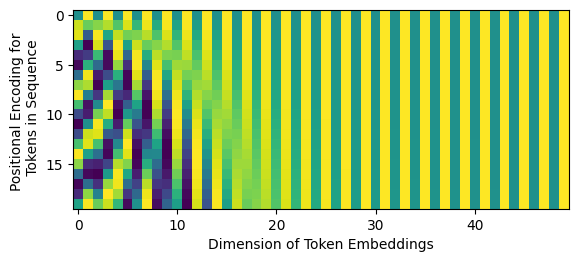

In [ ]:
C = 50 # 토큰의 임베딩 크기
T = 20 # 시퀀스 길이

pos = PositionalEncoder(C)

fig, ax = plt.subplots()

# 입력 텐서를 생성하여 PositionalEncoder에 전달
input_tensor = torch.zeros((T, 1, C))

# 도식화할 때 배치가 갖는 차원을 없애기 위해 squeeze 적용
ax.imshow(pos(input_tensor).squeeze())

ax.set_xlabel("Dimension of Token Embeddings")
ax.set_ylabel("Positional Encoding for \n Tokens in Sequence")

plt.show()

![image](https://user-images.githubusercontent.com/76621046/159208871-8ae4a2ad-98f3-429f-8b67-21873560247c.png)

그림 3.6-9 위치 인코딩의 시각화


 squeeze 한 후 도식화한 위치 임베딩은 (C, T) = (20, 50)의 모양으로 출력된 것을 확인할 수 있다.
```

위 셀을 실행하면 위치 인코딩에 대한 출력으로 나온 값은 그 모양이 (T, 1, C)가 된다. 우리가 갖고 있는 시퀀스에 위치 인코딩을 적용시키기 위해서는 시퀀스과 위치 인코딩 값을 더해주어야 한다. 따라서 임베딩 차원과 같은 차원을 갖는 것을 알 수 있다.

### 8. 트랜스포머 구현 (HW)

이제 트랜스포머를 구성하는 모든 요소를 만들었으니 합쳐서 트랜스포머 구동을 위한 코드를 완성해보자!

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, h_dim, n_enc, n_dec, n_head=3):
        """ 완전한 트랜스포머 모델을 구현해보기.

        매개변수(Parameters)
        ----------
        dim : int
            소스와 타켓 시퀀스를 이루는 토큰의 차원 (`d`).

        h_dim : int
            각각의 feed forward 층에 있는 뉴런 개수.

        n_enc : int
            순차적으로 적용할 인코더 층의 개수.

        n_dec : int
            순차적으로 적용할 디코더 층의 개수.

        n_head : int
            각 multi-head attention에서 사용할 attention head의 개수.

        """
        super().__init__()
        # ‘PositionalEncoder`를 알맞은 임베딩 차원으로 구현해보기
        self.pos_enc = PositionalEncoder(dim)

        # `TransformerEncoder`와 `TransformerDecoder`에 해당하는 두 리스트를 생성
        # 그 길이는 각각 `n_enc`과 `n_dec`.
        # 우리는 __call__`에 여러 개의 인코더와 디코더를 적용하기 위해 생성한 리스트를 바탕으로 반복할 것이다.
        self.enc_layers = nn.ModuleList([TransformerEncoder(dim, h_dim, n_head) for _ in range(n_enc)])
        self.dec_layers = nn.ModuleList([TransformerDecoder(dim, h_dim, n_head) for _ in range(n_dec)])

        # sofrmax 확률이 각 토큰에 대하여 계산되기 이전에
        # 최종적으로 디코더가 최종적으로 출력하는 값을 ’해석‘할
        # torch.nn의 Linear layer를 인스턴스하기
        #
        # 밀집층은 ’d’ 차원의 벡터를 ‘d’ 차원으로 가져가야 한다.
        # glorot_normal을 weight initializer로 사용해라.
        self.out_dense = nn.Linear(dim, dim)
        nn.init.xavier_normal_(self.out_dense.weight)

    def forward(self, src, tgt):
        """ 완전한 트랜스포머 forward pass를 수행

        매개변수(Parameters)
        ----------
        src : 집합[numpy.ndarray, torch.Tensor], shape=(T, N, d)
            소스 시퀀스의 batch.

        tgt : 집합[numpy.ndarray, torch.Tensor], shape=(t, N, d)
            타겟 시퀀스의 batch.

        반환 값(Returns)
        -------
        torch.Tensor, shape=(t, N, d)
        """
        # 소스 시퀀스에 대한 위치 인코딩을 계산하고
        # 소스 시퀀스에 구한 것을 더해라.
        src = src + self.pos_enc(src)

        # 인코더 층의 리스트에 대해서 반복
        # 각 층에서 얻은 출력을 다음 층에서의 입력으로 사용
        # 디코더에서 사용할 인코더의 마지막 입력값을 저장하는 것도 유의
        for enc in self.enc_layers:
            src = enc(src)
        enc_out = src

        # 타겟 시퀀스에 대한 위치 인코딩을 계산하고
        # 타겟 시퀀스에 구한 것을 더해라.
        tgt = tgt + self.pos_enc(tgt)

        # 디코더 층의 리스트에 대해서 반복
        # 각 층에서 얻은 출력을 다음 층에서의 입력으로 사용
        for dec in self.dec_layers:
            tgt = dec(enc_out, tgt)

        # 마지막 밀집층을 적용하고 그 출력을 반환
        return self.out_dense(tgt)

트랜스포머 모델까지 형성했으니 이제 모델이 학습을 진행할 차례만 남았다. 모델 학습 과정에서 얻은 손실 및 정확도 변화를 우리가 확인할 필요가 있다.

앞서 정의 내린 트랜스포머 모델이 갖는 입력 중 feedforward 은닉 차원은 30, 인코더와 디코더 층은 각각 2개, 어텐션 헤드는 4로 설정한 다음 모델 학습을 진행해 볼 것이다. 이제 항상 해왔듯이 신경망 학습을 위해 최적화 도구(optimizer)와 함께 트랜스포머 모델을 불러와 보도록 하자. 최적화 도구로는 Adam을 사용할 것인데 이 Adam은 모델, 트랜스포머가 갖는 일반적인 매개변수에 대해 최적화를 진행해줄 것이다. 이 개념을 이해하고 아래에 모델로 트랜스포머를 불러오고 최적화 과정까지 정의해보도록 하자.

In [ ]:
d = train_src_one_hot.shape[-1]
# Transformer의 feedforward 은닏 차원
h_dim = 30
# 인코더 층 개수
n_enc = 2
# 디코더 층 개수
n_dec = 2
# 어텐션 헤드 개수
n_head = 4

# numpy로 되어 있는 데이터를 torch의 Tensor로 변경해주어야 모델과 옵티마이저로 입력이 가능하다.
train_src_one_hot = torch.from_numpy(train_src_one_hot)
train_tgt_one_hot = torch.from_numpy(train_tgt_one_hot)
train_truth_inds = torch.from_numpy(train_truth_inds).long()


model = Transformer(dim=d, h_dim=h_dim, n_enc=n_enc, n_dec=n_dec, n_head=n_head)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

마지막으로, 아래에 loop 코드를 이용하여 학습 과정을 짜보도록 한다. Epoch 수는 자유롭게 정해도 좋지만 먼저 1회 실시해본 후 정확도를 확인해보도록 한다. 처음부터 너무 많은 epoch를 행하면 학습하는데 상당한 시간이 소요될 수 있으니 1 epoch를 시작으로 점차 늘려가 보면서 정확도가 높아지는 epoch를 찾아보는 것이 좋을 것이다. 늘 그랬듯이 학습의 효율성을 위해 batch 크기를 정해주어야 하고 시퀀스의 길이 또한 알아야 한다. 학습 과정에서 예측값과 참값 간 손실은 softmax_crossentropy을 통해 처리해주고 이번엔 정확도를 계산하는 코드도 같이 작성해보라. 코드 작성을 끝낸 후 셀을 실행해보면 그래프에 손실은 점점 감소하고 정확도는 점차 증가하는 모습이 나타난 것을 확인할 수 있을 것이다.

In [ ]:
batch_size = 10
num_epochs = 1

dataset_size = train_src_one_hot.shape[1]

for epoch_cnt in range(num_epochs):
    idxs = np.arange(dataset_size)
    np.random.shuffle(idxs)

    for batch_cnt in range(0, dataset_size // batch_size):
        # adjusting the lr seems to help speed up
        # convergence a bit but it isn't really necessary
        if batch_cnt == 7500:
            optimizer = optim.Adam(model.parameters(), lr=1e-5)

        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]

        # since the data are shape (T, N, ...), we need to
        # index into the 1st dimension with `batch_indices`
        src_batch = train_src_one_hot[:, batch_indices]
        tgt_batch = train_tgt_one_hot[:, batch_indices]
        truth_batch = train_truth_inds[:, batch_indices]

        pred = model(src_batch, tgt_batch)

        pred = pred.view(-1, pred.shape[-1])
        truth_batch = truth_batch.view(-1)

        loss = criterion(pred, truth_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (pred.argmax(dim=1) == truth_batch).float().mean().item()


        if batch_cnt % 1000 == 0 and batch_cnt > 0:
            print(f"Batch {batch_cnt}: Loss = {loss.item()}, Accuracy = {acc}")


Batch 1000: Loss = 1.1669546365737915, Accuracy = 0.671999990940094
Batch 2000: Loss = 0.198356494307518, Accuracy = 0.9599999785423279
Batch 3000: Loss = 0.10173504799604416, Accuracy = 0.984000027179718
Batch 4000: Loss = 0.02607559785246849, Accuracy = 0.9919999837875366
Batch 5000: Loss = 0.025712639093399048, Accuracy = 0.9919999837875366
Batch 6000: Loss = 0.006362572778016329, Accuracy = 1.0
Batch 7000: Loss = 0.005109712481498718, Accuracy = 1.0
Batch 8000: Loss = 0.001242885715328157, Accuracy = 1.0
Batch 9000: Loss = 0.003236816730350256, Accuracy = 1.0
Batch 10000: Loss = 0.0008211961830966175, Accuracy = 1.0
Batch 11000: Loss = 0.0869530662894249, Accuracy = 0.9959999918937683
Batch 12000: Loss = 0.004862938076257706, Accuracy = 0.9959999918937683


### 9. 암호화된 문장 해독
일정 수준 이상의 정확도를 보인 트랜스포머 모델을 학습을 통해 얻었다면, 새롭게 얻은 encrypted text 혹은 cipher text라고도 하는 암호화된 문장을 바로 다시 해독하는 과정도 가능하다. 먼저 one-hot 인코딩 방식으로 주어진 데이터를 디코딩하는 과정을 거치고, 그다음 one-hot 문장을 실제 토큰으로 다시 바꾸는 과정을 거치면 일정 이상의 정확도를 갖는 해독화된 문장을 얻을 수 있을 것이다. 다시 정리하자면 트랜스포머 모델을 이용해 우리는 다음 순서에 나올 토큰을 얻을 것이다. 여기에 사용되는 방식은 ‘greedy decoding’이라고 불리는 방식이며 이는 토큰과 각 토큰에 해당하는 확률이 주어지면 그중 가장 높은 확률을 갖는 토큰을 argmax 함수로 출력해내는 방식이라고 간단하게 말할 수 있겠다. 즉, argmax를 이용해 다음에 나올 확률이 가장 높은 토큰을 계속해서 출력해나가면 된다. 아래의 셀에 ‘greedy decoding’ 방식을 이용한 코드를 작성해보자.

In [ ]:
# 추론을 위해 ‘greedy decoding’을 활용
test_src_one_hot = torch.from_numpy(test_src_one_hot)
test_tgt_one_hot = torch.zeros_like(test_src_one_hot)
test_tgt_one_hot[0, :, -2] = 1  # 모든 시퀀스를 시작 토큰(start token)으로 시작하도록 한다.

test_src_one_hot = test_src_one_hot.to(torch.float32)
test_tgt_one_hot = test_tgt_one_hot.to(torch.float32)

model.eval()  # 추론 모드로 전환

with torch.no_grad():  # 그래디언트 계산 비활성화
    for i in range(len(test_tgt_one_hot)-1):
        # 타켓 시퀀스에서 첫 번째 ‘i’ 토큰들에 접근
        tgt = test_tgt_one_hot[:i+1]

        # 완전한 소스 시퀀스와 전체에서 일부만 존재하는 타겟 시퀀스 보내기
        pred = model(test_src_one_hot, tgt)

        # `i+1`번째 토큰을 가장 예측 점수가 높은 토큰으로 업데이트
        ind = pred[-1].argmax(dim=-1)
        test_tgt_one_hot[i+1, range(len(ind)), ind] = 1

In [ ]:
import string

# 다음의 것으로 알파벳을 정의하자: ` ` = space, ~ = start, ! = stop
ALPHA_STA_STO = string.ascii_lowercase + " ~!"

decoded_str = []

# batch가 갖는 차원에 맞게 반복
for seq_one_hot in test_tgt_one_hot.transpose(1, 0):
    # 시퀀스의 one-hot 인코딩에 기초에 알파벳으로 인덱스하기
    seq_text = "".join([ALPHA_STA_STO[i] for i in seq_one_hot.argmax(dim=-1).cpu().numpy()])
    decoded_str.append(seq_text)

decoded_str

['~i love you so much honey', '~blahblahllahblahblahbblh']

위 두 개의 셀을 실행함으로써 어느 정도 정확한 실제 문장을 추론하는 것이 가능하다.

### 10. Attention head의 시각화
여기까지 성공했다면 마지막으로 우리가 사용했던 모든 attention head를 시각화해보는 이를 확인하면서 본 실습을 마무리하자. 아래의 것은 단순 예시이고 이름을 설정할 때 반드시 본인이 모델 정의를 내릴 때 사용했던 속성의 이름으로 설정해야 한다는 점을 잊지 말자!

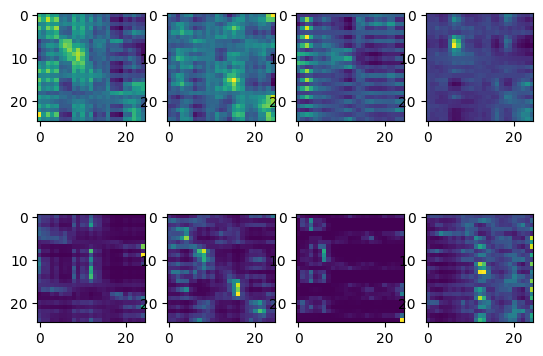

In [ ]:
# 이미 학습을 거친 트랜스포머 모델로 모델 설정
model = model

#  모델의 인코더 목록의 이름으로 설정 (string)
enc_layers = "enc_layers"

# 트랜스포머 모델의 디코더 목록의 이름으로 설정 (string으로)
dec_layers = "dec_layers"

# 트랜스포머 인코더에 쓰인 MultiHeadAttention`  self-attention의 이름으로 설정 (string으로)
enc_self_attn = "self_attn"

# 트랜스포머 디코더에 쓰인 MultiHeadAttention`  self-attention의 이름으로 설정 (string으로)
dec_self_attn = "self_attn"

# # 트랜스포머 디코더에 쓰인 MultiHeadAttention`  encoder-decoder의 이름으로 설정 (string으로)
dec_enc_dec_attn = "enc_dec_attn"


enc_layers_ls = getattr(model, enc_layers)

n_layers = len(enc_layers_ls)
n_heads = len(getattr (enc_layers_ls[0], enc_self_attn).Wq)

fig, ax = plt.subplots(n_layers, n_heads)
ax = np.array(ax).reshape(n_layers, n_heads)

for i, layer in enumerate(enc_layers_ls):
    a_ij = getattr(layer, enc_self_attn).a_ij[:, 1] # shape: (T, h, t)
    for j in range(a_ij.shape[1]):
        head_aij = a_ij[:, j]
        ax[i, j].imshow(head_aij);




![image](https://user-images.githubusercontent.com/76621046/159209073-288ba6b4-5b9b-4f3a-bcd5-38bf01ec87ee.png)

그림 3.6-10 Attention head 시각화 예시

먼저 위 셀을 실행하면 위 그림처럼 우리가 트랜스포머에서 사용한 어텐션 헤드가 어떻게 생겼는지 확인할 수 있다. 나머지 셀도 마저 실행해보고 어텐션 헤드가 어떻게 생겼는지 눈으로 확인해보면 이 개념을 보다 명확히 이해하는데 도움이 될 것이다.


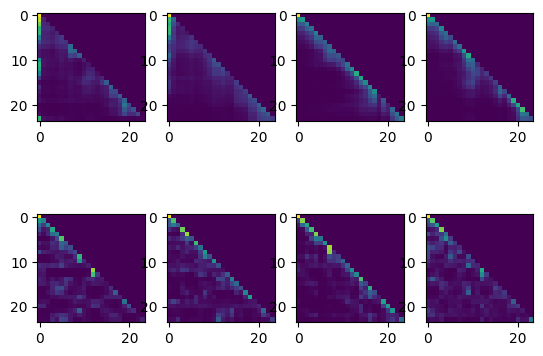

In [ ]:
dec_layers_ls = getattr(model, dec_layers)

n_layers = len(dec_layers_ls)
n_heads = len(getattr(dec_layers_ls[0],dec_self_attn).Wq)

fig ,ax = plt.subplots(n_layers, n_heads)
ax = np.array(ax).reshape(n_layers, n_heads)

for i, layer in enumerate(dec_layers_ls):
    a_ij = getattr(layer, dec_self_attn).a_ij[:, 0] # shape: (T, h, t)
    for j in range(a_ij.shape[1]):
        head_aij = a_ij[:, j]
        ax[i, j].imshow(head_aij);

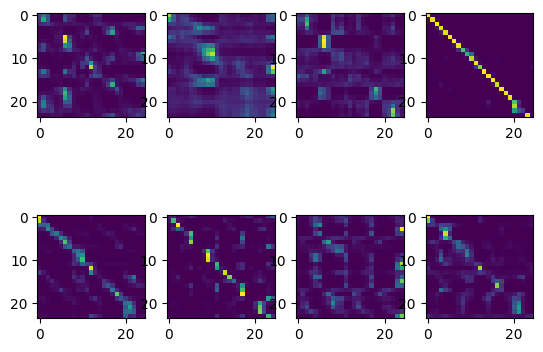

In [ ]:
n_layers = len(dec_layers_ls)
n_heads = len(getattr(dec_layers_ls[0], dec_enc_dec_attn).Wq)

fig, ax = plt.subplots(n_layers, n_heads)
ax = np.array(ax).reshape(n_layers, n_heads)

for i, layer in enumerate(dec_layers_ls):
    a_ij = getattr(layer, dec_enc_dec_attn).a_ij[:, 1] # shape: (T, h, t)
    for j in range (a_ij.shape[1]):
        head_aij = a_ij[:, j]
        ax[i, j].imshow(head_aij);

### 배운 내용 되돌아보기

□ 트랜스포머는 Seq2Seq의 순환적 구조에서 기인한 한계점을 극복했다. 문장의 길이에 관계없이 정해진 횟수만큼 인코더와 디코더의 층이 반복되는 구조를 가지고 있다. 각 층이 끝나는 구간에는 Batch Normalization과 Residual Connection이 적용되어 있어 신경망의 성능을 꾸준히 향상시켜준다.

□ Scaled Dot Product Attention 기법을 통해 한 차례의 연산으로 Attention Weight을 산출할 수 있게 했다. 이는 직전 디코더의 hidden state(Q)와 인코더의 hidden state들(K, V)의 내적으로 나타내며, 두 배열 사이의 연관성을 나타낸다.

□ Q, K, V를 활용한 Attention Weight 연산은 수행하는데 오래 걸리기에, Multihead Attention 기법을 통해서 h개의 Attention head로 나누어 동시다발적으로 진행해주었다. 이로써 수행하는데 걸리는 시간이 효과적으로 줄어든다.

□ 디코더에서는 타겟 시퀀스가 입력되는데, 이 과정에서 t번째 토큰을 예측하는데 타겟 시퀀스의 t번째 이후의 토큰들이 영향력을 행사하는 것은 좋지 않다. 이를 방지하기 위해 마스킹을 도입하였다. 마스킹을 통해서 t번째 토큰을 예측하는 데는 그 이전의 토큰들만 관여할 수 있도록 조정해주었다.

□ 트랜스포머 모델이 반영할 수 없는 토큰의 위치 정보를 고려하기 위해 위치 인코딩(positional encoding)이란 개념을 도입하였다. 이는 토큰이 갖고 있던 기존 임베딩에 토큰의 위치 정보를 반영할 수 있는 벡터를 함께 고려하고자 하는 개념이다. 이때의 벡터는 코사인 및 사인 함수에 의존하였다.

□ 트랜스포머에 필요한 구성들을 모아 하나의 트랜스포머 모델을 형성하였다. 이때 사용한 attention head를 시각화해보았는데 이 과정으로 추상적으로 다가왔을 attention head가 무엇인지 눈으로 확인할 수 있었다.

□ 완성된 트랜스포머 모델로 주어진 암호화된 문장을 해독할 수 있었다. ‘greedy decoding’이란 방식을 이용해 계속해서 그 다음에 이어질 토큰을 예측할 수 있다는 것을 확인했다. 여기서 ‘greedy decoding’이란 argmax 함수를 통해 가장 높은 확률로 뒤이어 나올 토큰을 예측하는 방식이었다.


## 6절. 신경망 성능 향상을 위한 기법들을 마무리하며

이번 6절에서는 신경망의 성능을 높이기 위해 도입된 추가 기법들에 대해서 살펴보았다. 데이터 정규화의 장점을 빌려온 Batch Normalization과 Layer Normalization. Gradient의 최솟값을 설정해줌으로써 역전파의 성능 저하를 방지한 Residual Connection. 그리고 이 둘을 이용하여 순환적 구조의 한계를 이겨낸 Transformer. 이 기법들은 자연어 처리 분야뿐만 아니라 컴퓨터 비전 분야에서도 유용한 툴로 사용되고 있다.

실습 11을 통해 Attention 기반 모델인 트랜스포머를 자세히 살펴보았다. 이 모델은 Scaled Dot Product Attention 기법을 통해 모든 입력 값을 한 번에 받아서 한 번에 결과를 출력해준다. 또한, Multihead Attention을 통해 이 연산에 걸리는 시간을 획기적으로 줄였다.
    

#### 참고문헌
1. Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).
2. 《stuart》, <https://liger82.github.io/nlp/dialogue/2020/04/19/paper-non-autoregressive-3. dialog-state-tracking.html>, 2022.02.15.
4. https://www.tensorflow.org/text/tutorials/transformer    